In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import shutil
import random
from torchvision.utils import make_grid
import torch.nn.functional as F
from tqdm import tqdm
import cv2

In [2]:
batch_size = 64
epochs = 10
texture_block = 8
learning_rate = 0.001
weight_decay = 1e-5

In [3]:
if os.path.exists("/kaggle/working/best-checkpoint.ckpt"):
  os.remove("/kaggle/working/best-checkpoint.ckpt")

In [4]:
# Define data paths
data_dir = "/kaggle/input/deepfake/DFWILD"
train_fake_dir = os.path.join(data_dir, "train_fake", "fake")
train_real_dir = os.path.join(data_dir, "train_real")
test_fake_dir = os.path.join(data_dir, "valid_fake", "fake")
test_real_dir = os.path.join(data_dir, "valid_real", "real")

In [5]:
# Paths to the working directories
working_fake_dir = "/kaggle/working/fake"
working_real_dir = "/kaggle/working/real"

if not (os.path.exists(working_fake_dir) and os.path.exists(working_real_dir)):
    # Create the working directories if they don't exist
    os.makedirs(working_fake_dir, exist_ok=True)
    os.makedirs(working_real_dir, exist_ok=True)

    # Get the list of all images in train_fake and train_real directories
    fake_images = [f for f in os.listdir(train_fake_dir) if f.endswith((".png", ".jpg", ".jpeg"))]
    real_images = [f for f in os.listdir(train_real_dir) if f.endswith((".png", ".jpg", ".jpeg"))]

    # Determine the number of real images
    num_real_images = len(real_images)

    # Randomly sample a subset of fake images equal to the number of real images
    sampled_fake_images = random.sample(fake_images, num_real_images)

    # Copy the sampled fake images to the working_fake_dir
    for image in tqdm(sampled_fake_images, desc="Copying sampled fake images"):
        src_path = os.path.join(train_fake_dir, image)
        dst_path = os.path.join(working_fake_dir, image)
        shutil.copy(src_path, dst_path)

    # Copy all real images to the working_real_dir
    for image in tqdm(real_images, desc="Copying real images"):
        src_path = os.path.join(train_real_dir, image)
        dst_path = os.path.join(working_real_dir, image)
        shutil.copy(src_path, dst_path)

train_fake_dir = working_fake_dir
train_real_dir = working_real_dir

Copying real images: 100%|██████████| 42690/42690 [05:50<00:00, 121.68it/s]


In [6]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Without face cropping

In [7]:
# Custom Dataset Loassertader for Real and Fake Images
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label, transform=None):
        self.image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.label

### With face cropping

In [8]:
# class CustomDataset(torch.utils.data.Dataset):
#     def __init__(self, image_dir, label, transform=None, cascade_path="haarcascade_frontalface_default.xml"):
#         self.image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
#         self.label = label
#         self.transform = transform
#         self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + cascade_path)
#         self.default_image = Image.new('RGB', (224, 224), color='gray')  # Default placeholder image

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         image_path = self.image_paths[idx]
#         # image = Image.open(image_path).convert("RGB")
#         # if self.transform:
#         #     image = self.transform(image)
#         image = cv2.imread(image_path)
#         if image is None:
#             print(f"Error: Unable to read the image file at {image_path}. Returning default image.")
#             return self.default_image, self.label

#         # Remove the background and make it black
#         gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         _, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
#         black_background = np.zeros_like(image)
#         image = cv2.bitwise_and(image, image, mask=mask)

#         # Convert the image to grayscale for face detection
#         gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#         # Detect faces in the image
#         faces = self.face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

#         if len(faces) == 0:
#             print(f"No faces detected in the image at {image_path}. Returning default image.")
#             if self.transform:
#                 return self.transform(self.default_image), self.label
#             return self.default_image, self.label

#         # Assume the largest detected face is the main face
#         x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])

#         # Crop the face from the image
#         cropped_face = image[y:y+h, x:x+w]

#         # Convert the cropped face to PIL Image
#         cropped_face = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)
#         cropped_face_image = Image.fromarray(cropped_face)

#         # Apply transformations if any
#         if self.transform:
#             cropped_face_image = self.transform(cropped_face_image)

#         return cropped_face_image, self.label


In [9]:
# Load datasets using CustomDataset for both real and fake images
train_real_dataset = CustomDataset(image_dir=train_real_dir, label=1, transform=transform)
train_fake_dataset = CustomDataset(image_dir=train_fake_dir, label=0, transform=transform)

train_dataset = torch.utils.data.ConcatDataset([train_fake_dataset, train_real_dataset])

# Split train_dataset into training and validation datasets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create test dataset
test_real_dataset = CustomDataset(image_dir=test_real_dir, label=1, transform=transform)
test_fake_dataset = CustomDataset(image_dir=test_fake_dir, label=0, transform=transform)

test_dataset = torch.utils.data.ConcatDataset([test_fake_dataset, test_real_dataset])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train Loader Grids:


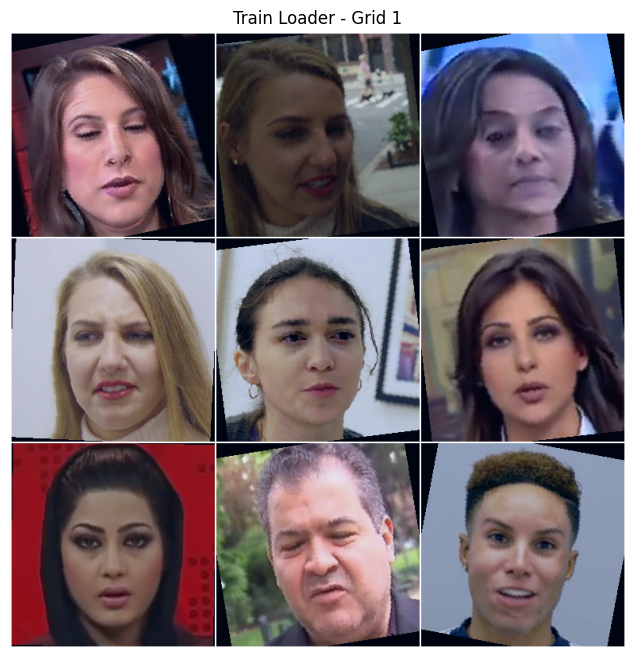

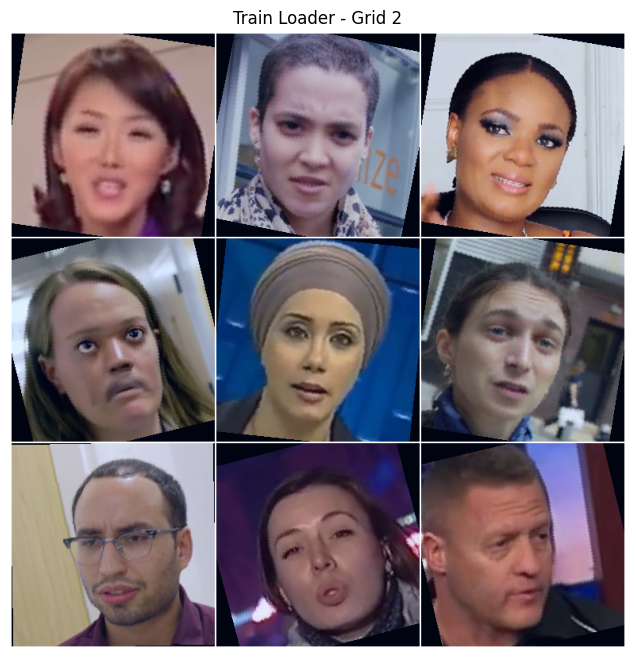

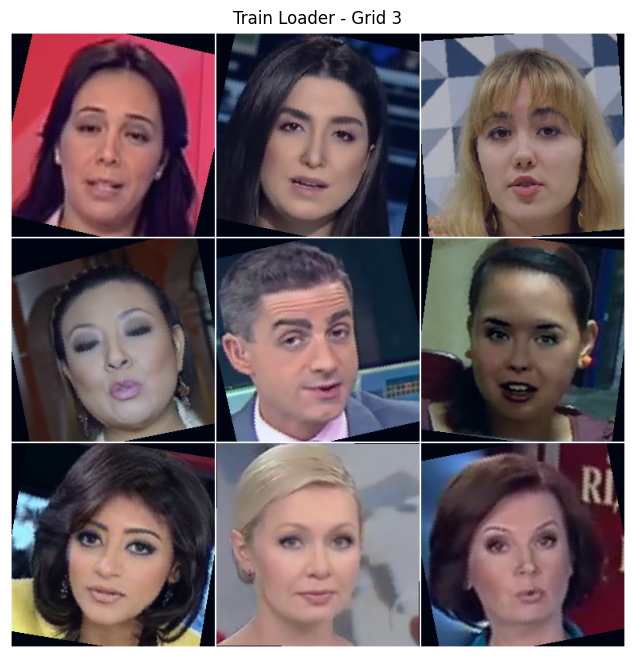

Validation Loader Grids:


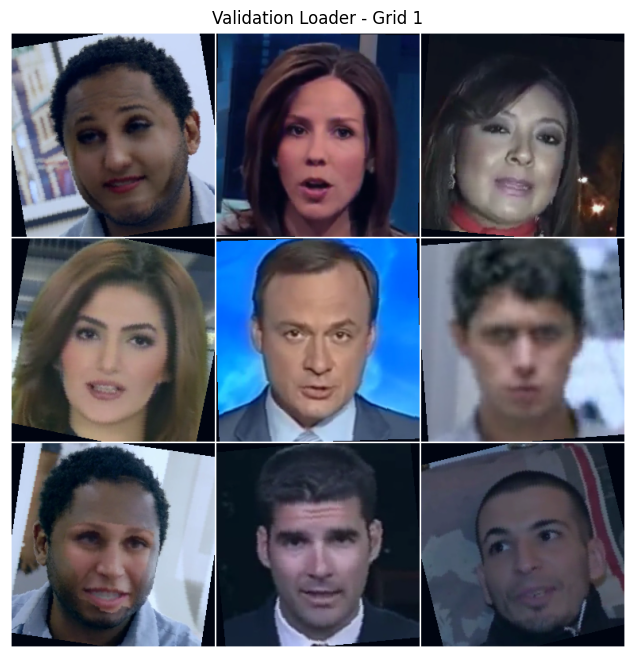

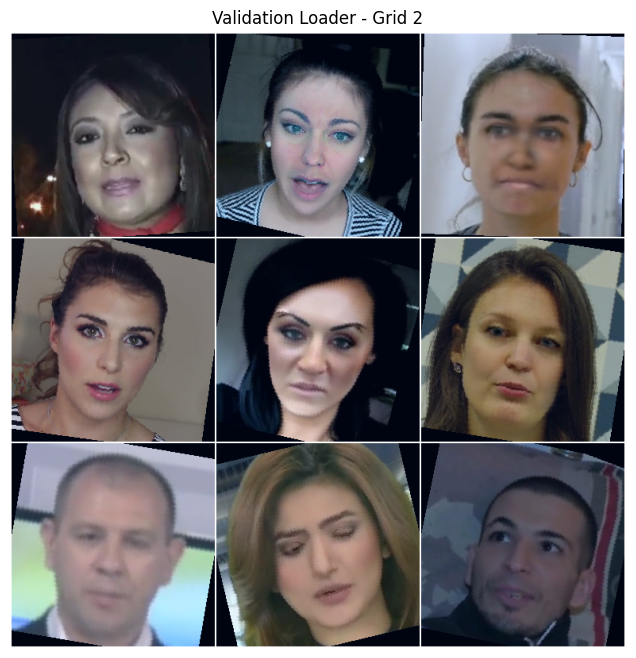

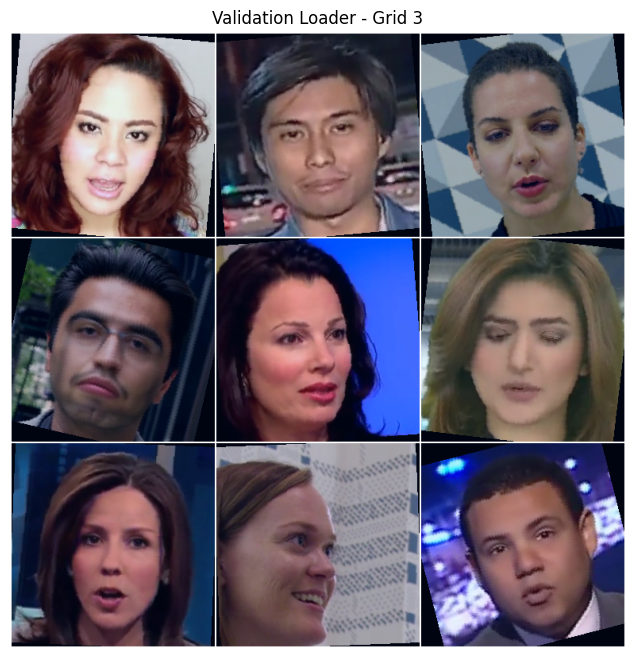

Test Loader Grids:


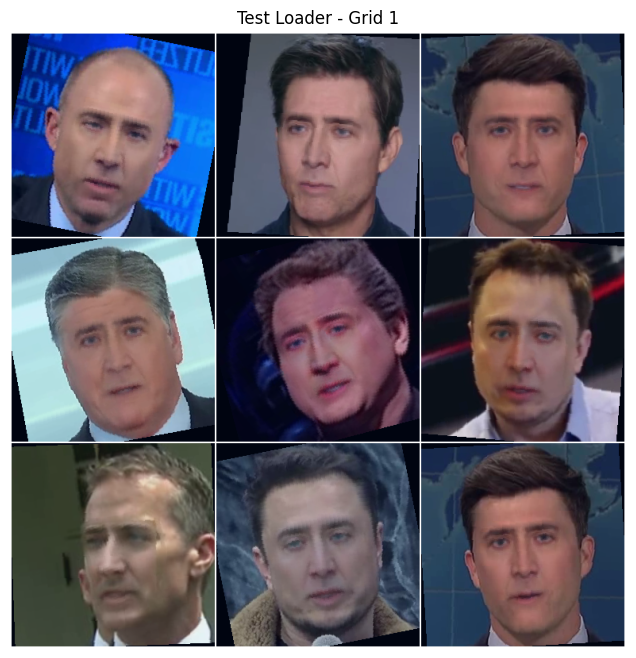

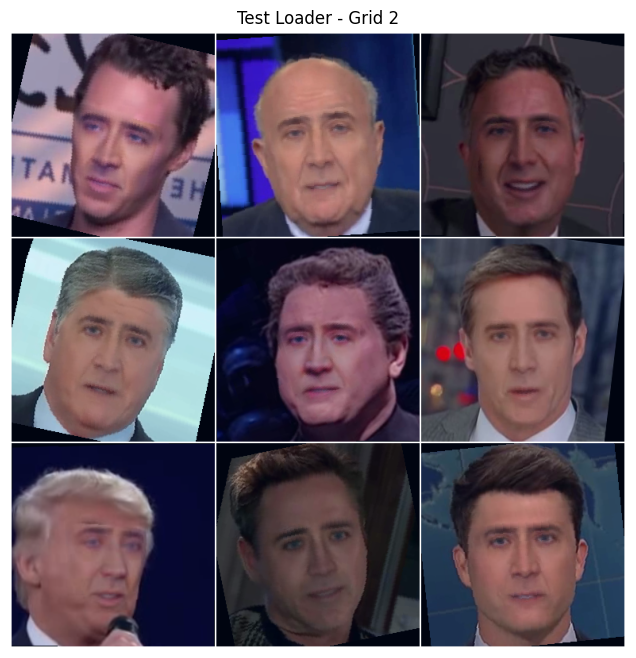

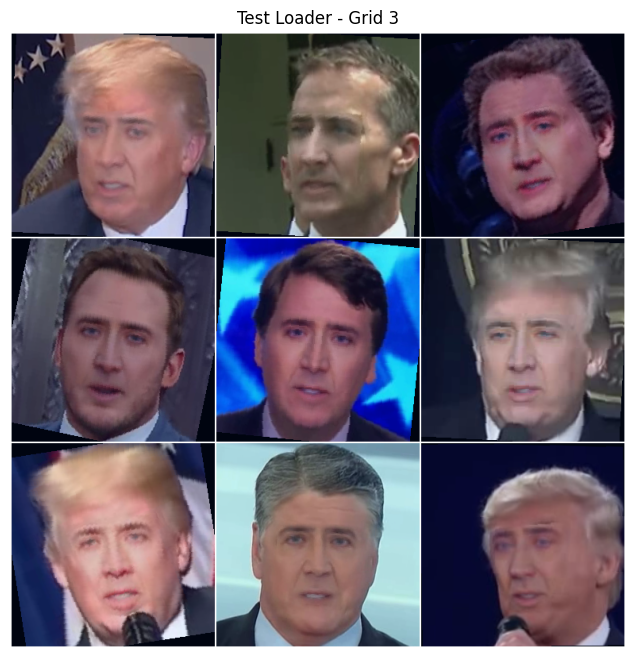

In [10]:
def show_images_from_dataloader(dataloader, grids=3, grid_size=3, title="Dataset Images"):
    """
    Display a specified number of grids, each showing a random selection of images from the dataloader.

    Parameters:
    - dataloader (DataLoader): The PyTorch DataLoader to sample images from.
    - grids (int): Number of grids to display.
    - grid_size (int): Size of the grid (grid_size x grid_size images per grid).
    - title (str): Title for the grids.
    """
    for grid in range(grids):
        # Sample a batch of images
        data_iter = iter(dataloader)
        images, labels = next(data_iter)

        # Select random images for the grid
        selected_indices = random.sample(range(len(images)), grid_size * grid_size)
        selected_images = [images[idx] for idx in selected_indices]

        # Create a grid of images
        grid_images = make_grid(selected_images, nrow=grid_size, normalize=True, pad_value=1)

        # Convert to numpy for display
        np_grid_images = grid_images.permute(1, 2, 0).cpu().numpy()

        # Display the grid
        plt.figure(figsize=(8, 8))
        plt.imshow(np_grid_images)
        plt.axis('off')
        plt.title(f"{title} - Grid {grid + 1}")
        plt.show()

# Display 9 random images in 3 grids for train, validation, and test loaders
print("Train Loader Grids:")
show_images_from_dataloader(train_loader, grids=3, grid_size=3, title="Train Loader")

print("Validation Loader Grids:")
show_images_from_dataloader(val_loader, grids=3, grid_size=3, title="Validation Loader")

print("Test Loader Grids:")
show_images_from_dataloader(test_loader, grids=3, grid_size=3, title="Test Loader")


In [11]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        efficientnet = models.efficientnet_b4(pretrained=True)
        for param in efficientnet.parameters():
            param.requires_grad = False
        self.features = efficientnet.features

    def forward(self, x, target_block=None):
        """
        Extract features up to a specified block.

        Args:
            x (torch.Tensor): Input tensor (e.g., an image batch).
            target_block (int, optional): Block index up to which to extract features.
                                         If None, extract features from all blocks.

        Returns:
            dict: A dictionary with keys as block indices and values as the extracted features.
        """
        if target_block == 8:
            return self.features(x)
        layers_output = {}
        for idx, layer in enumerate(self.features):
            x = layer(x)
            layers_output[idx] = x
            # Stop processing if the target block is reached
            if target_block is not None and idx == target_block:
                break
        if target_block is None:
            target_block = 8
        return layers_output[target_block]

In [12]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # First Convolutional Block
        self.conv1 = nn.Conv2d(1792, 1024, kernel_size=3, stride=1, padding=1)  
        self.bn1 = nn.BatchNorm2d(1024)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  

        # Second Convolutional Block
        self.conv2 = nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1)  
        self.bn2 = nn.BatchNorm2d(512)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 

        # Third Convolutional Block
        self.conv3 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)  
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  

        # Fully Connected Layers
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 1)  # Binary classification

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        # Flatten
        x = x.view(x.size(0), -1) 
        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification
        return x

In [13]:
class DeepFakeClassifier(nn.Module):
    def __init__(self, texture_layer):
        super(DeepFakeClassifier, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.classifier = Classifier()
        self.texture_layer = texture_layer

    def forward(self, x):
        x = self.feature_extractor(x, self.texture_layer)
        x = self.classifier(x)
        return x

In [14]:
class CustomCriterion:
    def __init__(self):
        self.bce_loss = nn.BCELoss()

    def compute_loss(self, outputs, labels):
        return self.bce_loss(outputs, labels)

In [15]:
class DeepFakeClassifierTrainer(pl.LightningModule):
    def __init__(self, texture_layer, learning_rate, weight_decay):
        super(DeepFakeClassifierTrainer, self).__init__()
        self.texture_layer = texture_layer
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.model = DeepFakeClassifier(texture_layer)
        self.criterion = CustomCriterion()
        self.training_losses = []
        self.training_accuracies = []
        self.validation_losses = []
        self.validation_accuracies = []
        self.test_labels = []
        self.test_outputs = []

    def forward(self, x):
        return self.model(x)

    def display_metrics(self):
        plt.figure(figsize=(18, 12))

        plt.subplot(2, 2, 1)
        plt.plot(range(1, len(self.training_losses) + 1), self.training_losses, label="Training Loss")
        plt.title("Training Loss Over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(range(1, len(self.validation_losses) + 1), self.validation_losses, label="Validation Loss")
        plt.title("Validation Loss Over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(range(1, len(self.training_losses) + 1), self.training_accuracies, label="Training Accuracy")
        plt.title("Training Accuracy Over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(range(1, len(self.validation_losses) + 1), self.validation_accuracies, label="Validation Accuracy")
        plt.title("Validation Accuracy Over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.show()

    def get_confusion_matrix(self):
        all_preds = np.concatenate(self.test_outputs)
        all_labels = np.concatenate(self.test_labels)
        cm = confusion_matrix(all_labels, all_preds > 0.5)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.show()
        return cm

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        inputs = inputs.to(self.device)  # Ensure inputs are on the correct device
        labels = labels.float().unsqueeze(1).to(self.device)  # Ensure labels are on the correct device
        outputs = self.model(inputs)
        loss = self.criterion.compute_loss(outputs, labels)
        preds = (outputs > 0.5).float()
        acc = accuracy_score(labels.cpu(), preds.cpu())
        self.training_losses.append(loss.item())
        self.training_accuracies.append(acc)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        inputs = inputs.to(self.device)  # Ensure inputs are on the correct device
        labels = labels.float().unsqueeze(1).to(self.device)  # Ensure labels are on the correct device
        outputs = self(inputs)
        loss = self.criterion.compute_loss(outputs, labels)
        preds = (outputs > 0.5).float()
        acc = accuracy_score(labels.cpu(), preds.cpu())
        self.validation_losses.append(loss.item())
        self.validation_accuracies.append(acc)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        if batch_idx == 0:
            self.test_labels = []
            self.test_outputs = []

        inputs, labels = batch
        inputs = inputs.to(self.device)  # Ensure inputs are on the correct device
        labels = labels.float().unsqueeze(1).to(self.device)  # Ensure labels are on the correct device
        outputs = self(inputs)
        loss = self.criterion.compute_loss(outputs, labels)
        preds = (outputs > 0.5).float()
        acc = accuracy_score(labels.cpu(), preds.cpu())

        self.test_labels.append(labels.cpu().numpy())
        self.test_outputs.append(outputs.cpu().numpy())

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)  # Add L2 regularization

    # def on_fit_start(self):
    #     """Ensure compatibility with DDP setup."""
    #     if self.trainer.global_rank == 0:
    #         self.display_model_summary()

    def display_model_summary(self):
        print("Model Summary:")
        print(self.model)
        self.display_trainable_parameters()

    def display_trainable_parameters(self):
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        non_trainable_params = total_params - trainable_params
        print("\nParameter Summary Table:")
        print(f"{'Parameter Type':<25}{'Count':<15}")
        print(f"{'Trainable Parameters':<25}{trainable_params:<15}")
        print(f"{'Non-Trainable Parameters':<25}{non_trainable_params:<15}")
        print(f"{'Total Parameters':<25}{total_params:<15}\n")

    def save_weights(self, path):
        torch.save(self.model.state_dict(), path)

    def load_weights(self, path):
        self.model.load_state_dict(torch.load(path))

    def classify_image(self, image_path):
        self.model.eval()
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(self.device)  # Ensure image is on the correct device
        with torch.no_grad():
            output = self.model(image)
            prediction = "Real" if output.item() > 0.5 else "Fake"
        print(f"Prediction: {prediction}, Confidence: {output.item():.4f}")

In [16]:
# Instantiate the model
model = DeepFakeClassifierTrainer(texture_block, learning_rate, weight_decay)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 212MB/s]


In [17]:
# Define trainer
trainer = pl.Trainer(
    callbacks=[
        pl.callbacks.ModelCheckpoint(
            monitor="val_loss",
            save_top_k=1,
            mode="min",
            dirpath='/kaggle/working/',
            filename="best-checkpoint"
        )
    ],
    max_epochs=epochs,
    accelerator="gpu",
    # devices=2,
    # strategy='ddp_notebook'
)

In [18]:
# Path to the last checkpoint
checkpoint_path = "/kaggle/working/best-checkpoint.ckpt"

# Check if the checkpoint exists
if os.path.exists(checkpoint_path):
    print(f"Resuming training from checkpoint: {checkpoint_path}")
    trainer.fit(model, train_loader, val_loader, ckpt_path=checkpoint_path)
else:
    print("Starting training from scratch.")
    trainer.fit(model, train_loader, val_loader)


Starting training from scratch.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [19]:
# trainer.fit(model, train_loader, val_loader)

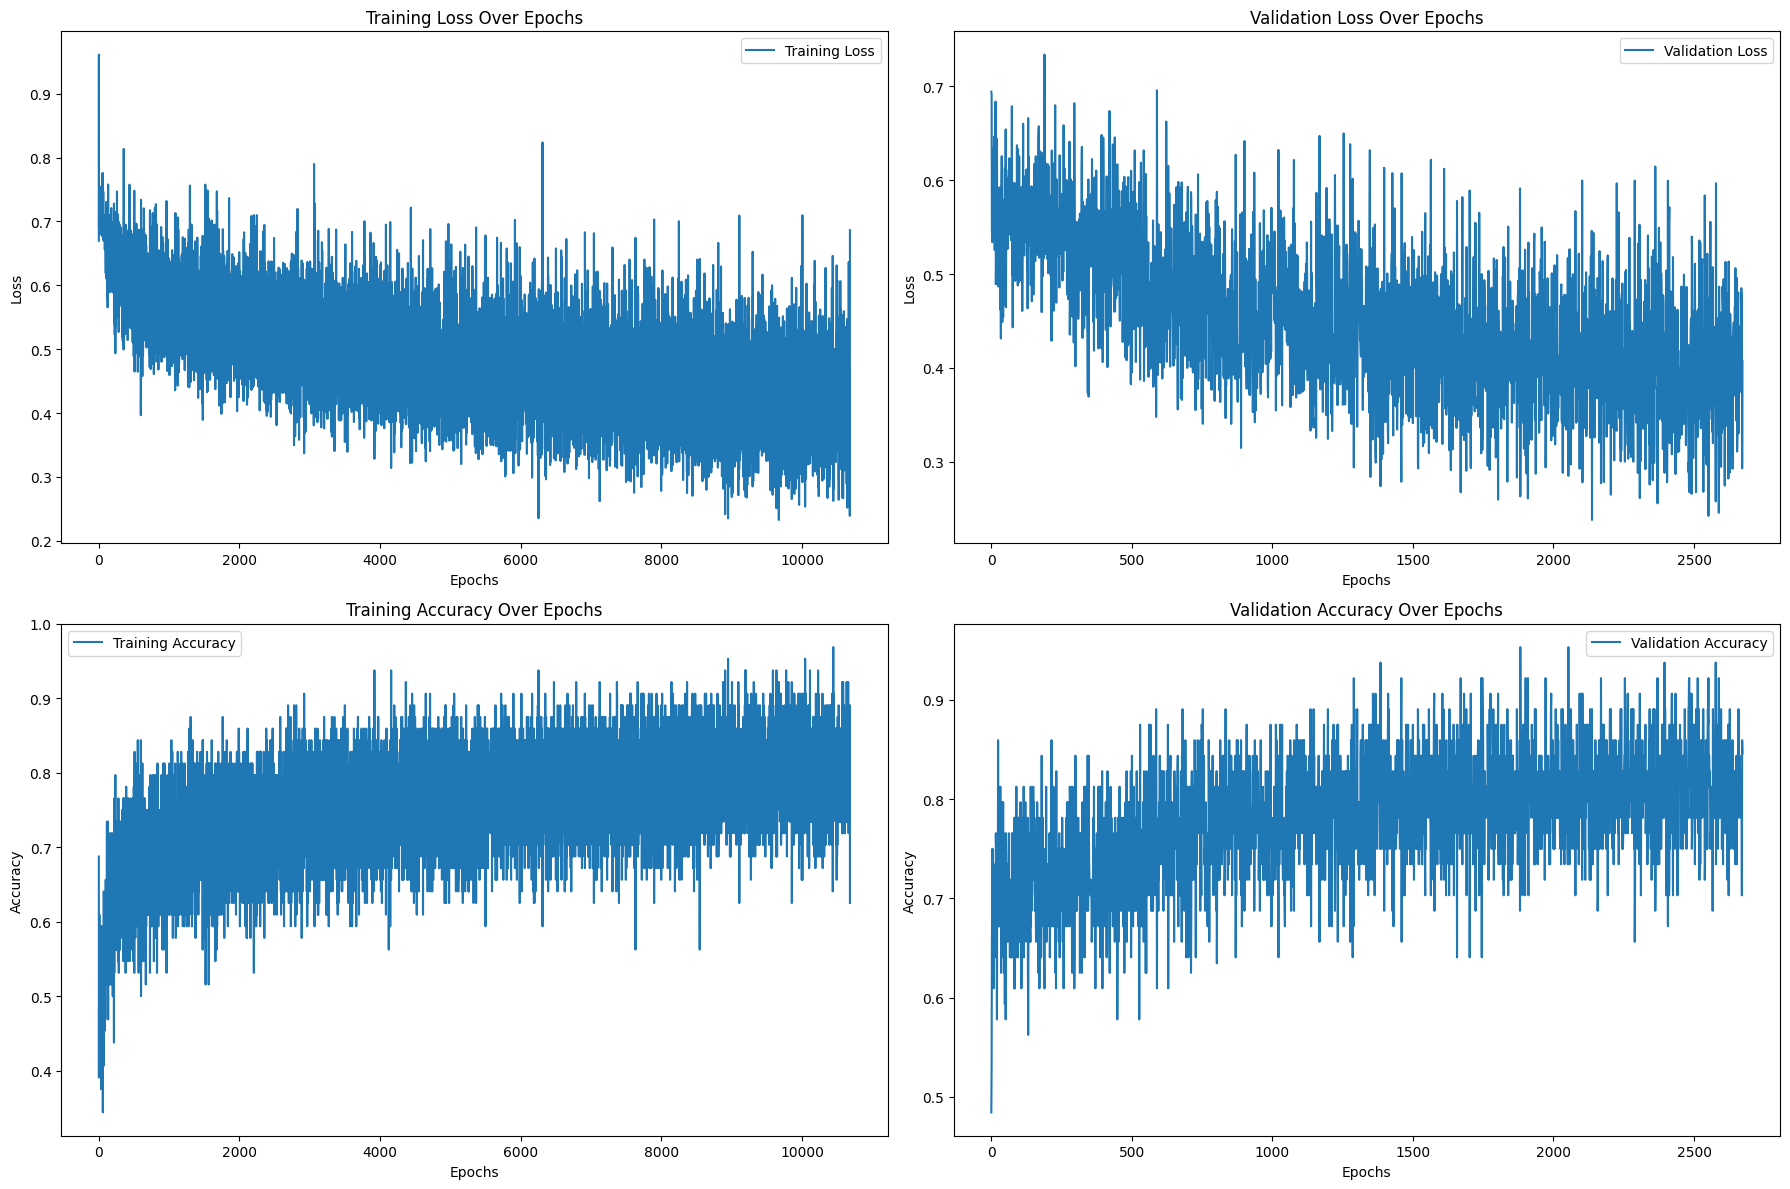

In [20]:
model.display_metrics()

In [21]:
trainer.test(model, test_loader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7467448115348816     │
│         test_loss         │    0.5225206017494202     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5225206017494202, 'test_acc': 0.7467448115348816}]

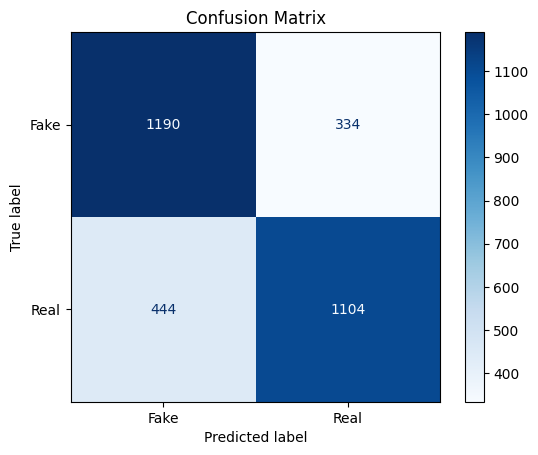

array([[1190,  334],
       [ 444, 1104]])

In [22]:
model.get_confusion_matrix()